### Practical_RL week3 homework

In this notebook we'll get more perspective on how value-based methods work. 

We assume that you've already done either seminar_main or seminar_alternative.

To begin with, __please edit qlearning.py__ - just copy your implementation from the first part of this assignment.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

bash: ../xvfb: No such file or directory
env: DISPLAY=:1


## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [5]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [6]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, next_s, r)
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward  

mean reward -9.33


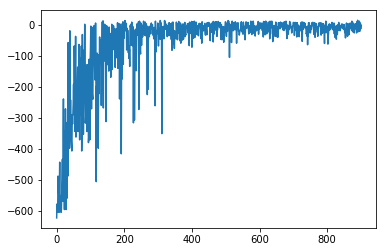

In [7]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))    
    if i % 100 ==0:
        clear_output(True)
        print("mean reward", np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

### 1.1 reducing epsilon

Try decreasing agent epsilon over time to make him reach positive score.

The straightforward way to do so is to reduce epsilon every N games:
* either multiply agent.epsilon by a number less than 1 (e.g. 0.99)
* or substract a small value until it reaches 0

You can, of-course, devise other strategies.

__The goal is to reach positive reward!__

In [15]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

mean reward 8.18


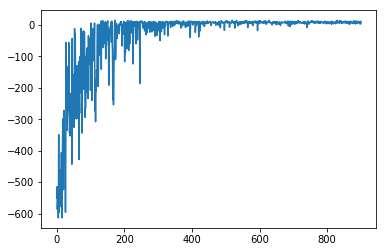

In [16]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    if i % 100 ==0:
        clear_output(True)
        print("mean reward", np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

## 2. Expected value SARSA (1 pt)

Let's try out expected-value SARSA. You will have to implement EV-SARSA as an agent, resembling the one you used in qlearning.py ,

```<go to expected_value_sarsa.py and implement missing lines in getValue(state)```

__[bonus, 2pt]__ implement EV-SARSA for softmax policy:

$$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau}  \over {\sum_{a_j}  e ^{Q(s,a_j) / \tau }}} $$

In [34]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [35]:
from expected_value_sarsa import EVSarsaAgent
agent = EVSarsaAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

### Train EV-SARSA

Note that it uses __the same update parameters as__ qlearning so you adapt use the ```play_and_train``` code above.

Please try both constant epsilon = 0.25 and decreasing epsilon.

mean reward 8.26


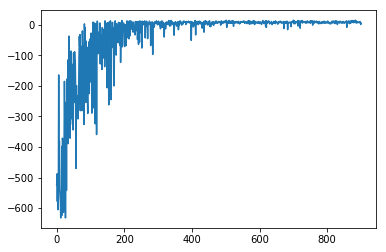

In [36]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    if i % 100 ==0:
        clear_output(True)
        print("mean reward", np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

### EV_SARSA with softmax policy

In [37]:
from expected_value_sarsa import EVSarsaAgent
agent = EVSarsaAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                     getLegalActions = lambda s: range(n_actions),
                     policy='softmax', tau=1)

mean reward 8.2


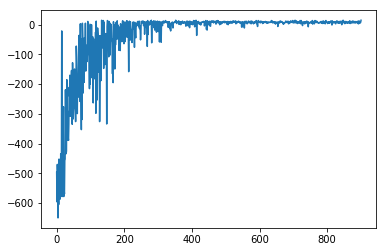

In [38]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    if i % 100 ==0:
        clear_output(True)
        print("mean reward", np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

## 3. Continuous state space (2 pt)

Use agent to train on CartPole-v0

This environment has a continuous number of states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state:[-0.03814109  0.04169256  0.00059264 -0.02625649]


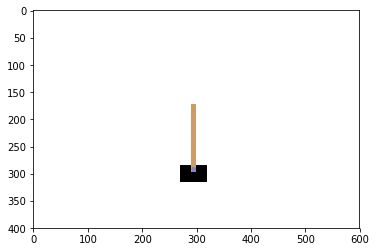

In [39]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s"%(env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

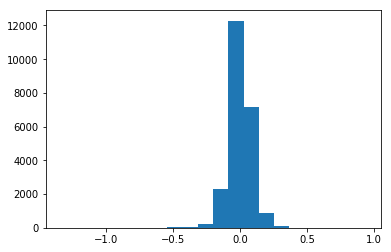

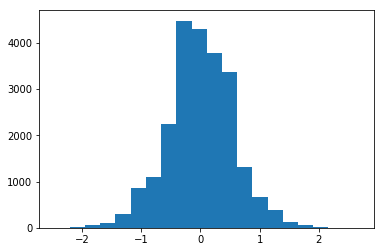

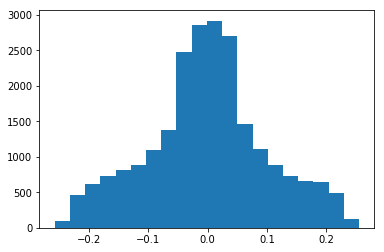

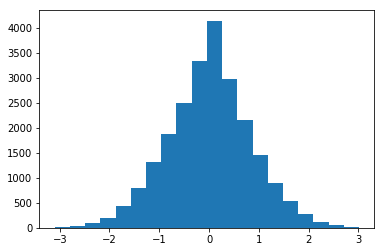

In [42]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Binarize environment

In [52]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self,state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        n_digits = [2, 1, 2, 1]
        state = [round(s, n_digits[i]) for i, s in enumerate(state)]
        
        return tuple(state)

In [53]:
env = Binarizer(gym.make("CartPole-v0"))

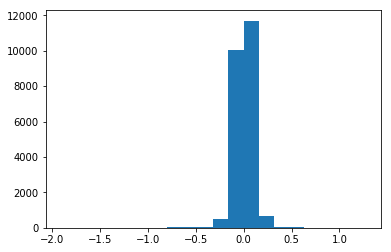

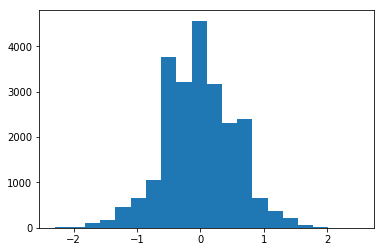

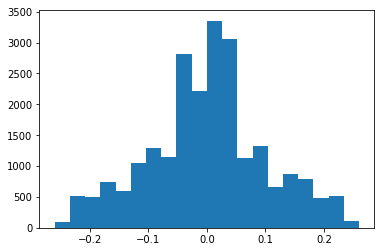

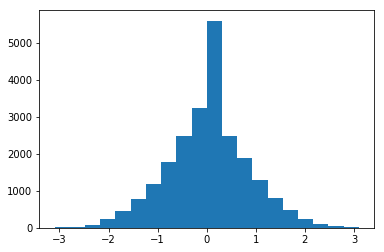

In [54]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn

In [55]:
agent = QLearningAgent(alpha=0.5, epsilon=0.99, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

4.964338674360123e-05


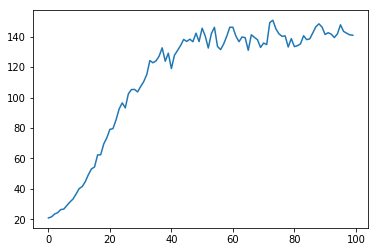

In [56]:
rewards = []
mean_rewards = []
for i in range(100000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.9999
    if i % 1000 == 0:
        clear_output(True)
        print(agent.epsilon)
        mean_rewards.append(np.mean(rewards))
        plt.plot(mean_rewards)
        rewards = []
        plt.show()

## 3.2 EV-sarsa on CartPole

Now train the `EVSarsaAgent` on CartPole-v0 env with binarizer you used above for Q-learning.

In [59]:
env = Binarizer(gym.make("CartPole-v0"))

agent = EVSarsaAgent(alpha=0.5, epsilon=0.99, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

4.964338674360123e-05


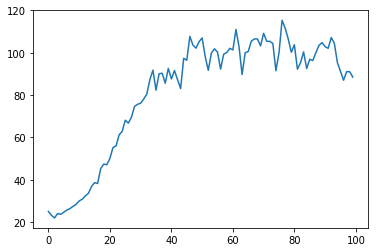

In [60]:
rewards = []
mean_rewards = []
for i in range(100000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.9999
    if i % 1000 == 0:
        clear_output(True)
        print(agent.epsilon)
        mean_rewards.append(np.mean(rewards))
        plt.plot(mean_rewards)
        rewards = []
        plt.show()

## 4. Experience replay (4 pts)

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [177]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if self.__len__() == self._maxsize:
            self._storage.pop(0)
        self._storage.append(data)
        
    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        if batch_size > self.__len__():
            idxes = range(self.__len__())
        else:
            idxes = np.random.choice(range(self.__len__()), batch_size, replace=False)
        
        ###Your code: collect <s,a,r,s',done> for each index
        obs_batch = []
        act_batch = []
        rew_batch = []
        next_obs_batch = []
        done_mask = []
        for idx in idxes:
            obs_batch.append(self._storage[idx][0])
            act_batch.append(self._storage[idx][1])
            rew_batch.append(self._storage[idx][2])
            next_obs_batch.append(self._storage[idx][3])
            done_mask.append(self._storage[idx][-1])
        
        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask

Now let's use this buffer to improve training:

In [178]:
env = Binarizer(gym.make("CartPole-v0"))
agent = QLearningAgent(alpha=0.5, epsilon=0.99, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [179]:
def play_and_train(env, agent, replay, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    batch_size = 4
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        next_s,r,done,_ = env.step(a)
    
        ###Your code here: store current <s,a,r,s'> transition in buffer
        replay.add(s, a, r, next_s, done)
        ###Your code here: train on both current
        obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = replay.sample(batch_size)
        for i in range(len(obs_batch)):
            agent.update(obs_batch[i], act_batch[i], next_obs_batch[i], rew_batch[i])
        
        s = next_s
        total_reward +=r
        if done:break
    
    return total_reward

Train with experience replay

4.964338674360123e-05


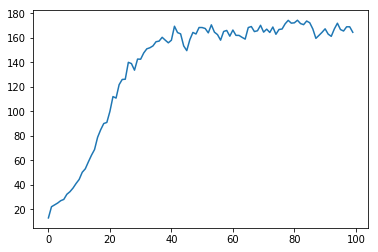

In [180]:
rewards = []
mean_rewards = []
for i in range(100000):
    rewards.append(play_and_train(env, agent, replay))
    agent.epsilon *= 0.9999
    if i % 1000 == 0:
        clear_output(True)
        print(agent.epsilon)
        mean_rewards.append(np.mean(rewards))
        plt.plot(mean_rewards)
        rewards = []
        plt.show()

### Bonus I: TD($ \lambda $) (5+ points)

There's a number of advanced algorithms you can find in week 3 materials (Silver lecture II and/or reading about eligibility traces). One such algorithm is TD(lambda), which is based on the idea of eligibility traces. You can also view it as a combination of N-step updates for alll N.
* N-step temporal difference from Sutton's book - [url](http://incompleteideas.net/sutton/book/ebook/node73.html)
* Eligibility traces from Sutton's book - [url](http://incompleteideas.net/sutton/book/ebook/node72.html)
* Blog post on eligibility traces - [url](http://pierrelucbacon.com/traces/)



Implementing this algorithm will prove more challenging than q-learning or sarsa, but doing so will earn you a deeper understanding of how value-based methods work [in addition to some bonus points].

More kudos for comparing and analyzing TD($\lambda$) against Q-learning and EV-SARSA in different setups (taxi vs cartpole, constant epsilon vs decreasing epsilon).

### Bonus II: More pacman (5+ points)

Remember seminar_main where your vanilla q-learning had hard time solving Pacman even on a small grid. Now's the time to fix that issue.

We'll focus on those grids for pacman setup.
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumGrid__
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumClassic__

Even if you adjust N_TRAIN_GAMES to 10^5 and N_TOTAL_GAMES to 10^5+100 (100 last games are for test), pacman won't solve those environments

The problem with those environments is that they have a large amount of unique states. However, you can devise a smaller environment state by choosing different observation parameters, e.g.:
 * distance and direction to nearest ghost
 * where is nearest food
 * 'center of mass' of all food points (and variance, and whatever)
 * is there a wall in each direction
 * and anything else you see fit 
 
Here's how to get this information from [state](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/pacman.py#L49),
 * Get pacman position: [state.getPacmanPosition()](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/pacman.py#L128)
 * Is there a wall at (x,y)?: [state.hasWall(x,y)](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/pacman.py#L189)
 * Get ghost positions: [state.getGhostPositions()](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/pacman.py#L144)
 * Get all food positions: [state.getCapsules()](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/pacman.py#L153)
 
You can call those methods anywhere you see state.
 * e.g. in [agent.getValue(state)](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/qlearningAgents.py#L52)
 * Defining a function that extracts all features and calling it in [getQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/qlearningAgents.py#L38) and [setQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/qlearningAgents.py#L44) is probably enough.
 * You can also change agent parameters. The simplest way is to hard-code them in [PacmanQAgent](https://github.com/yandexdataschool/Practical_RL/blob/master/week2/assignment/qlearningAgents.py#L140)

Also, don't forget to optimize ```learning_rate```, ```discount``` and ```epsilon``` params of model, this may also help to solve this env.